### PAP - Password Access Protocol
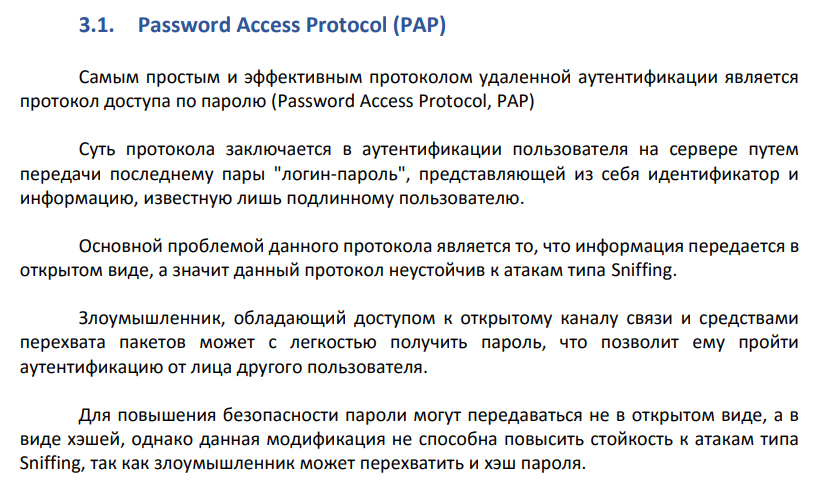

In [3]:
from hashlib import sha256

class Server():
    def __init__(self):
        self._base = {}
    def register(self, login, password):
        if login not in self._base.keys():
            self._base[login] = sha256(bytes(password, encoding = "utf-8")).digest()
            print("[Server]: состояние базы:", self._base)
            return True
        else:
            print("[Server]: пользователь с данным логином зарегистрирован в системе")
            return False
    def login(self, login, password):
        if login not in self._base.keys():
            print("[Server]: неверный логин или пароль")
            return False
        elif self._base[login] != sha256(bytes(password, encoding = "utf-8")).digest():
            print("[Server]: неверный логин или пароль")
            return False
        else: 
            print("[Server]: аутентификация пройдена")
            return True
server = Server()  

In [4]:
class User():
    def __init__(self, login, password):
        self.login = login
        self._pass = password
    def do_login(self, server):
        print("[User {0}]: попытка аутентификации:".format(self.login))
        if server.login(self.login, self._pass):
            print("-- успешная аутентификация")
        else:
            print("-- ошибка аутентификации")
    def do_register(self, server):
        print("[User {0}]: процесс регистрации:".format(self.login))
        if server.register(self.login, self._pass):
            print("-- успешная регистрация")
        else:
            print("-- ошибка регистрации")

            
Bob = User("bob", "qwerty")
Bob.do_register(server)
Bob.do_login(server)

[User bob]: процесс регистрации:
[Server]: состояние базы: {'bob': b'e\xe8K\xe352\xfbxLH\x12\x96u\xf9\xef\xf3\xa6\x82\xb2qh\xc0\xeatK,\xf5\x8e\xe0#7\xc5'}
-- успешная регистрация
[User bob]: попытка аутентификации:
[Server]: аутентификация пройдена
-- успешная аутентификация


### С другим паролем:

In [5]:
Bob = User("bob", "qwert")
Bob.do_login(server)

[User bob]: попытка аутентификации:
[Server]: неверный логин или пароль
-- ошибка аутентификации


### CHAP - Challenge-Handshake Authentication Protocol
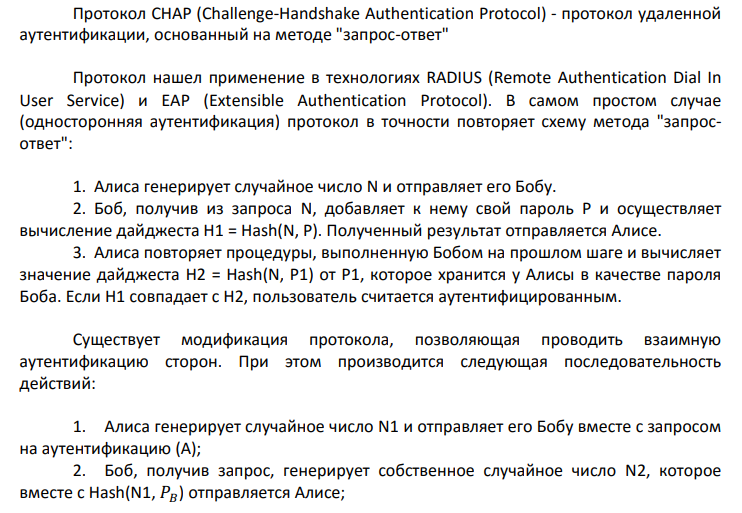
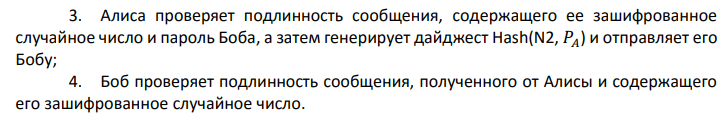

In [15]:
from hashlib import sha256
from Crypto import Random

class Server():
    def __init__(self):
        self._base = {}
        
    def get_N(self, login):
        if login in self._base.keys():
            print("[Server]: {0} запросил N, генерация N:".format(login))
            N = Random.get_random_bytes(128)
            print("-- сгенерировано N")
            self._base[login]["N"] = N
            return N
        return None
    
    def register(self, login, password):
        if login not in self._base.keys():
            self._base[login] = {}
            self._base[login].update({"password" : password})
            print("[Server]: состояние базы:", self._base)
            return True
        else:
            print("[Server]: пользователь с данным логином зарегистрирован в системе")
            return False
        
    def login(self, login, hash_from_user):
        N = self._base[login]["N"]
        self._base[login]["N"] = 0
        password = self._base[login]["password"]
        temp_hash = sha256(N + bytes(password, encoding = "utf-8")).digest()
        if login not in self._base.keys():
            print("[Server]: неверный логин или пароль")
            return False
        elif temp_hash != hash_from_user:
            print("[Server]: неверный логин или пароль")
            return False
        else: 
            print("[Server]: аутентификация пройдена")
            return True
alice = Server()  

In [16]:
class User():
    def __init__(self, login, password):
        self.login = login
        self._pass = password
        self.N = 0
    def do_login(self, server):
        print("[User {0}]: попытка аутентификации:".format(self.login))
        N = server.get_N(self.login)
        print("[User {0}]: от Server получено N: {1}\n".format(self.login, N))
        password = sha256(N + bytes(self._pass, encoding = "utf-8")).digest()
        if server.login(self.login, password):
            print("-- успешная аутентификация")
        else:
            print("-- ошибка аутентификации")
        self.N = 0
    def do_register(self, server):
        print("[User {0}]: процесс регистрации:".format(self.login))
        if server.register(self.login, self._pass):
            print("-- успешная регистрация")
        else:
            print("-- ошибка регистрации")

            
Bob = User("bob", "qwerty")
Bob.do_register(alice)
Bob.do_login(alice)

[User bob]: процесс регистрации:
[Server]: состояние базы: {'bob': {'password': 'qwerty'}}
-- успешная регистрация
[User bob]: попытка аутентификации:
[Server]: bob запросил N, генерация N:
-- сгенерировано N
[User bob]: от Server получено N: b'\xd8\xc6\xaf\xffT\x1d\xd8\xdd7\xc1[\x0c?H\x9ba:\x01fL\x15!\xb4\xc0H4\xee\xcf\x9e\xf0y\xc9\xcd\xd2\xfaO\xe4\x97$\xbc\x9e\xba\xb4\xd5R\xe5\x0b\x1b\xab2\xec\x19\xc1\x9f\x1d\x1eT\xb8\x94\xcd\xb5[\x81XM\xc7\xdb\x9ad\x0c\xf1\x9f\xcd\xed?\xe7\x9d\xca%\xa5\xb9\xaa\xc6\xc9C\xa5\xc1p\xe7\x81\x9d\xc4\x93\xbc\x91G\xc6\xce\x05\x89 (\x82\xe4\x01n\x86r\x05\x90\x84\x89q\x0b\xec,A\xf8T\xb8\x98\x9b\x0b\x02)e\x10\xf1'

[Server]: аутентификация пройдена
-- успешная аутентификация


### Модификация CHAP - Challenge-Handshake Authentication Protocol)

In [24]:
from hashlib import sha256
from Crypto import Random

class Alice():
    def __init__(self):
        self._base = {}
        self.login = "Alice"
        self._pass = "qweqwe"
        
    def get_N(self, login):
        if login in self._base.keys():
            print("-- [Alice]: {0} запросил N_1, генерация N_1".format(login))
            N = Random.get_random_bytes(128)
            print(N)
            self._base[login]["N"] = N
            return N
        return None
    
    def register(self, login, password):
        if login not in self._base.keys():
            self._base[login] = {}
            self._base[login].update({"password" : password})
            print("-- успешная регистрация {0}:".format(login))
            print("[Alice]: состояние базы:", self._base)
            return (self.login, self._pass)
        else:
            print("[Alice]: пользователь с данным логином зарегистрирован в системе")
            return False
        
    def do_login(self, login, hash_from_user, N_2):
        N = self._base[login]["N"]
        self._base[login]["N"] = 0
        password = self._base[login]["password"]
        temp_hash = sha256(N + bytes(password, encoding = "utf-8")).digest()
        if login not in self._base.keys():
            print("[Alice]: неверный логин или пароль")
            return False
        elif temp_hash != hash_from_user:
            print("[Alice]: неверный логин или пароль")
            return False
        else: 
            print("[Alice]: -- успешная аутентификация Bob")
            alice_hash = sha256(N_2 + bytes(self._pass, encoding = "utf-8")).digest()
            return alice_hash

In [27]:
class Bob():
    def __init__(self, password):
        self.login = "Bob"
        self._pass = password
        self.N_1 = 0
        self.N_2 = 0
        self._base = {}
        
    def do_Bob_login(self, server):
        print("[{0}]: попытка аутентификации {0}:".format(self.login))
        self.N_1 = server.get_N(self.login)
        self.N_2 = Random.get_random_bytes(128)
        print("[{0}]: генерация N_2:".format(self.login))
        print(self.N_2)
        password = sha256(self.N_1 + bytes(self._pass, encoding = "utf-8")).digest()
        alice_hash = server.do_login(self.login, password, self.N_2)
        if alice_hash:
            print("[{0}]: попытка аутентификации Alice:".format(self.login)) 
            alice_password = self._base["Alice"]["password"]
            if alice_hash == sha256(self.N_2 + bytes(alice_password, encoding = "utf-8")).digest():
                    print("-- успешная аутентификация Alice")
        else:
            print("-- ошибка аутентификации")
            
    def do_register(self, server):
        print("[{0}]: процесс регистрации:".format(self.login))
        (login, password) = server.register(self.login, self._pass)
        if login and password:
            print("-- успешная регистрация {0} у Bob:".format(login))
            
        else:
            print("-- ошибка регистрации {0}:".format(self.login))
        if login not in self._base.keys():
            self._base[login] = {}
            self._base[login].update({"password" : password})
            print("[{0}]: состояние базы:".format(self.login), self._base)
            return True
        else:
            print("[{0}]: пользователь с данным логином зарегистрирован в системе".format(self.login))
            return False

alice = Alice()              
Bob = Bob("qwerty")
Bob.do_register(alice)
Bob.do_Bob_login(alice)

[Bob]: процесс регистрации:
-- успешная регистрация Bob:
[Alice]: состояние базы: {'Bob': {'password': 'qwerty'}}
-- успешная регистрация Alice у Bob:
[Bob]: состояние базы: {'Alice': {'password': 'qweqwe'}}
[Bob]: попытка аутентификации Bob:
-- [Alice]: Bob запросил N_1, генерация N_1
b'\x88\xfa\xd1\x017\xef\x0fK\xcd\xf3\xcaG$\xf6\x18\x98\x87B\xc1`p\x8a\xdc\x08\xfd\x91Udu\x81\x82\xd0a0\xc5\x1fs\x89\x1b\xa6 \xfb\x9cu\x9c\xdc\xe9:\xa4\x95\xb7x\xb0$\xa8\xe3\xd7\xe9\x00=\xd5\x9c>\x12\xf4\x8a\x92\x89\xf8\xbb\x19)\xf1\xbf\x84\xb4\x1d\xa1\x1a\xda\xdc\xe4\xcbIb\xde}\xa9#Cm\x07\x01\x9c\xd7\xdcf\x96\x87\x9d\xe4yM\x89\xb4\x89\xa30\x02\xcc\xf09\xe2?\x8azj\xbdLmh\xcb\x04\xf3\xad\xfd\x1ek'
[Bob]: генерация N_2:
b'\x1cn\xf4;\xa2\xa2`I\x9c\x18s\x1e\xdf\x1f\x1c_5\x11U7L\x7f\xf2.\xb1\x7f|Ypc\x11\x84\xa3#\xb9\xba<\t\xe6-)\x19\xcf\x9b\x7fB\xac\x9c~\x0e\xb4`\x90q\xfcY\xe6\xa5\xc3q\xe90\x0f\xe8\xac\xcc\xc9\x95\x97\x1f\x86?y\xdf\xb6\x90\xb7t\xab\xbe\xa8\x92\xe7\x94\xa5rNxx\xe0\xf6\x17\xb2\r\xd5\xb3\xda\xf1\

### S/KEY

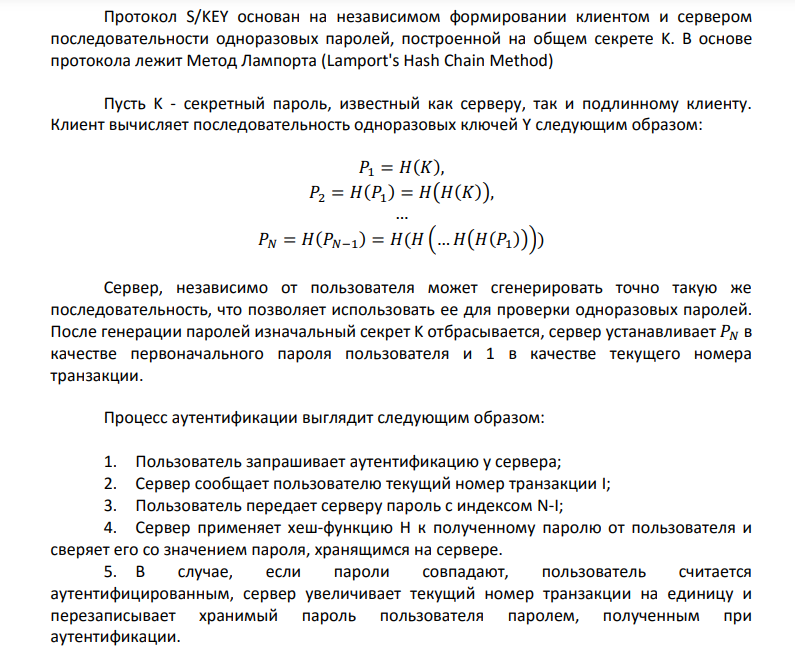

In [43]:
from Crypto import Random
from Crypto.Util.number import bytes_to_long
from hashlib import sha256

class Server:
    def __init__(self, K):
        self._K = K
        self._R = None
        self._passwords = {}
        self._current_pass = {}
        self._I = {}
            
    def _get_I(self, login):
        print("[Server]: пользователь запрашивает аутентификацию")
        if login in self._passwords.keys():
            return self._I[login]
        else:
            print("[Server]: ошибка генерации I")
            return None
    
    def generate_R(self):
        self._R = Random.get_random_bytes(128)
    
    def _generate_passwords(self):
        """
        - вычисление последовательности паролей:
        current_pass -> sha256(current_pass) -> sha256(sha256(current_pass))
        """
        current_pass = self._K + self._R
        passwords = []
        for _ in range(N_ROUNDS):
            i_hash = sha256(current_pass).digest()
            passwords.append(i_hash)
            current_pass = i_hash
        return passwords
        
        
    def register(self,login):
        """
        - генерация I
        - генерация R
        - генерация паролей
        для конкретного пользователя
        """
        if login not in self._passwords.keys():
            # задаем итерацию, R, генерируем пароли
            self._I[login] = 1
            self.generate_R()
            print("[Server]: регистрация " + login)
            self._passwords[login] = self._generate_passwords()
            print("-- задание текущего пароля")
            self._current_pass[login] = self._passwords[login][-1]
            print("[Server]: новый пользователь {0} зарегистрирован".format(login))
            print("[Server]: состояние базы: ", self._passwords, "\n")            
        else:
            print("[Server]: Такой пользователь существует")
    
    def do_login(self, login, i_pass):
        print("[Server]: сравнение полученного пароля с текущим паролем current_pass.")
        if sha256(i_pass).digest() == self._current_pass[login]:
            print("-- совпадение")
            self._I[login] += 1
            self._current_pass[login] = i_pass
            print("-- увеличение I на 1, перезапись текущего пароля")
            print("[Server]: успешная аутентификация")
        else:
            print("Неправильный пароль")

In [44]:
class User():
    def __init__(self, login, key):
        self.key = key
        self._passwords = []
        self.login = login
        
    def _generate_passwords(self, key):
        """
        - запрос R
        - вычисление последовательности паролей:
        current_pass -> sha256(current_pass) -> sha256(sha256(current_pass))
        """
        R = server._R
        current_pass = key + R
        for _ in range(N_ROUNDS):       
            i_hash = sha256(current_pass).digest()
            self._passwords.append(i_hash)
            current_pass = i_hash
        return self._passwords
    
    def register(self, server):
        server.register(self.login)
        self._passwords = self._generate_passwords(self.key)
        
    def do_login(self, server):
        """
        - запрос I
        - пароль для данной итерации
        - логин
        """
        
        I = server._get_I(self.login)
        print("[User]: с сервера получено I=",I)
        if I:
            print("[User]: {0} итерация".format(I))
            i_pass = self._passwords[N_ROUNDS-I-1]
            server.do_login(self.login, i_pass)
        else:
            print("-- неудачная аутентификация")

In [45]:
N_ROUNDS = 10

key = b"1"
server = Server(key)
user = User("Bob", key)
user.register(server)
user.do_login(server)
user.do_login(server)
user.do_login(server)

[Server]: регистрация Bob
-- задание текущего пароля
[Server]: новый пользователь Bob зарегистрирован
[Server]: состояние базы:  {'Bob': [b"\xb2\xba(K[J\x01\xca\xe1!\x82\x06'^\xb6\xa3*M\xc9\xf8e\xdd5\x93]S\x81\xe8z?\x10\x1e", b',\xb2\xf5\xffc\xa1\x86&\xd8\x04\xdbT\xf6\x8c\x9a\xc2j\xae\x13\xdbs\x97\x16ia\x03\rn\xfd\t\xf9+', b'q\xab\x07\xb0\xee-K\xd8hG\xfd\xb3fA2\n\xbf\xb6(\x9e\xfa\xbe\xc2,\x15R\xcc,"e!\xed', b'~\x1euK\x88E$Dh\xb3\xec\xc8\x8aJ*\x9f\x8br\x0c\xafL\xb7\xaf\xe4AY\x8e>\xdc~M\xb8', b'D\xd2\x08\xe9[\xe6\x9a*\x0b}_\x14D\x10\xf9\x07\xf1\xd1\x03\x12\x05\x15\xa4=\x83k\x93\xfa\x92\xf9sp', b'\x16\xe9\xcf"\x94\x16\x8f\x94\xbcT\xf6\x8drTF-\x0e()\xefL\xaa\xd7H\x90\xb0\xd9\xb3d7\xf9=', b'\xf9\xde\xf3\xb2\xd4\x9d\x12\xab\n\xd8tlIdC!j\xc7\x95\r\x15\xe9\xdf1\xbe\xbek\xc7K\xe5\xb3\x13', b'y\xac6\x1eL\x98\x86\xa1-\xf8\x0e\xdaU\xa4\xbdR\x19\x08U9\xe6s\xc7KG\x12\x9a\xcc\xb7`\x84\x10', b'\x96_T\xa9\xbd\x7f\x9as\xec^\x17\xe8S\xd5\xf5va\xed6\xc8\x9d\xb5\x9aA\xec\xb4\x8ch\x12\x1e\xd6\x98', b'o\x98S